# [S24] Introduction to Machine Learning: Bonus assignment
**Student name:** <font color='red'>Polina Pushkareva</font>

**Student email:** <font color='red'>p.pushkareva@innopolis.university</font>

## Task 1. Baseline model [0pt]

In [ ]:
# custom_model = CustomModel()
# custom_model.load_state_dict(torch.load('PolinaPushkareva.pt'))
# custom_model.eval()

## Task 2. Self-supervised learning [12pts]

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, datasets
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# load CIFAR-10 dataset
(x_train, _), (x_test, _) = datasets.cifar10.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

170498071/170498071 [==============================] - 4s 0us/step


In [4]:
# define the Autoencoder model
def build_autoencoder(input_shape):
    encoder_inputs = layers.Input(shape=input_shape)
    encoder = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoder_inputs)
    encoder = layers.MaxPooling2D((2, 2), padding='same')(encoder)
    encoder = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(encoder)
    encoder = layers.MaxPooling2D((2, 2), padding='same')(encoder)

    decoder = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(encoder)
    decoder = layers.UpSampling2D((2, 2))(decoder)
    decoder = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(decoder)
    decoder = layers.UpSampling2D((2, 2))(decoder)
    decoder_outputs = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(decoder)

    autoencoder = models.Model(encoder_inputs, decoder_outputs)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    return autoencoder

autoencoder = build_autoencoder(input_shape=(32, 32, 3))
autoencoder.summary()
autoencoder.fit(x_train, x_train, epochs=30, batch_size=128, shuffle=True, validation_data=(x_test, x_test))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 16)        4624      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 16)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 16)          2320  

In [5]:
# extract encoder part
encoder = models.Model(inputs=autoencoder.input, outputs=autoencoder.layers[4].output)

# freeze encoder weights
for layer in encoder.layers:
    layer.trainable = False

In [6]:
# load CIFAR-10 dataset again for classification
(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.1, stratify=y_train)

In [7]:
# build classification model
classification_model = models.Sequential([
    encoder,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(10, activation='softmax')
])

classification_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
classification_model.summary()

history = classification_model.fit(x_train, y_train, epochs=60, batch_size=128, shuffle=True, validation_data=(x_val, y_val))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_1 (Functional)        (None, 8, 8, 16)          5520      
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 256)               262400    
                                                                 
 dense_1 (Dense)             (None, 10)                2570      
                                                                 
Total params: 270490 (1.03 MB)
Trainable params: 264970 (1.01 MB)
Non-trainable params: 5520 (21.56 KB)
_________________________________________________________________
Epoch 1/60
40/40 [==============================] - 4s 76ms/step - loss: 2.2316 - accuracy: 0.1964 - val_loss: 2.0117 - val_accuracy: 0.2719
Epoch 2/6

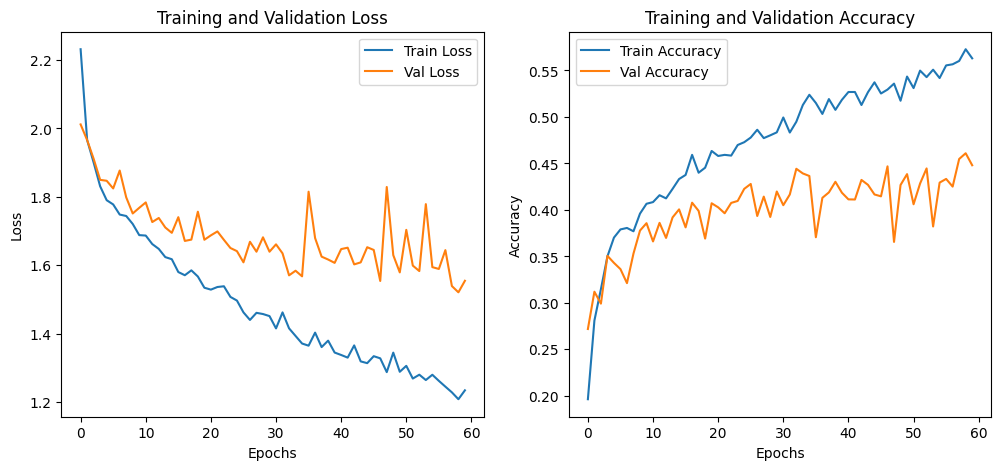

In [8]:
# plot the training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [9]:
# evaluate on test set
test_loss, test_accuracy = classification_model.evaluate(x_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

313/313 [==============================] - 1s 4ms/step - loss: 1.5586 - accuracy: 0.4497
Test Loss: 1.5586340427398682
Test Accuracy: 0.4496999979019165


## Task 3. Auxiliary learning [12 pts]

In [36]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, datasets
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# load the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

x_train, _, y_train, _ = train_test_split(x_train, y_train, test_size=0.9, stratify=y_train)

# define the combined model
def build_combined_model(input_shape):
    shared_layers = [
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2), padding='same'),
        layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2), padding='same')
    ]

    # classification head
    classification_head = [
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dense(10, activation='softmax')
    ]

    # reconstruction head
    reconstruction_head = [
        layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
        layers.UpSampling2D((2, 2)),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.UpSampling2D((2, 2)),
        layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')
    ]

    input_layer = layers.Input(shape=input_shape)

    shared_output = input_layer
    for layer in shared_layers:
        shared_output = layer(shared_output)

    classification_output = shared_output
    for layer in classification_head:
        classification_output = layer(classification_output)

    reconstruction_output = shared_output
    for layer in reconstruction_head:
        reconstruction_output = layer(reconstruction_output)

    classification_model = models.Model(input_layer, classification_output, name='classification_model')
    reconstruction_model = models.Model(input_layer, reconstruction_output, name='reconstruction_model')

    combined_output = [classification_output, reconstruction_output]
    combined_model = models.Model(input_layer, combined_output, name='combined_model')

    return classification_model, reconstruction_model, combined_model

# build models
classification_model, reconstruction_model, combined_model = build_combined_model(input_shape=(32, 32, 3))

# compile combined model
combined_model.compile(optimizer='adam',
                       loss=['sparse_categorical_crossentropy', 'mean_squared_error'],
                       loss_weights=[1.0, 0.5],
                       metrics=['accuracy'])

# train combined model
new_history = combined_model.fit(x_train, [y_train, x_train], epochs=30, batch_size=128, shuffle=True, validation_data=(x_test, [y_test, x_test]))


Epoch 1/30
40/40 [==============================] - 3s 42ms/step - loss: 2.1833 - dense_15_loss: 2.1583 - conv2d_39_loss: 0.0499 - dense_15_accuracy: 0.2162 - conv2d_39_accuracy: 0.3881 - val_loss: 1.9572 - val_dense_15_loss: 1.9423 - val_conv2d_39_loss: 0.0299 - val_dense_15_accuracy: 0.3151 - val_conv2d_39_accuracy: 0.5110
Epoch 2/30
40/40 [==============================] - 1s 26ms/step - loss: 1.8820 - dense_15_loss: 1.8663 - conv2d_39_loss: 0.0315 - dense_15_accuracy: 0.3350 - conv2d_39_accuracy: 0.5359 - val_loss: 1.7670 - val_dense_15_loss: 1.7549 - val_conv2d_39_loss: 0.0243 - val_dense_15_accuracy: 0.3724 - val_conv2d_39_accuracy: 0.5530
Epoch 3/30
40/40 [==============================] - 1s 22ms/step - loss: 1.6851 - dense_15_loss: 1.6728 - conv2d_39_loss: 0.0246 - dense_15_accuracy: 0.4158 - conv2d_39_accuracy: 0.6000 - val_loss: 1.7106 - val_dense_15_loss: 1.7002 - val_conv2d_39_loss: 0.0207 - val_dense_15_accuracy: 0.3865 - val_conv2d_39_accuracy: 0.6018
Epoch 4/30
40/40 [=

In [37]:
new_history.history.keys()

dict_keys(['loss', 'dense_15_loss', 'conv2d_39_loss', 'dense_15_accuracy', 'conv2d_39_accuracy', 'val_loss', 'val_dense_15_loss', 'val_conv2d_39_loss', 'val_dense_15_accuracy', 'val_conv2d_39_accuracy'])

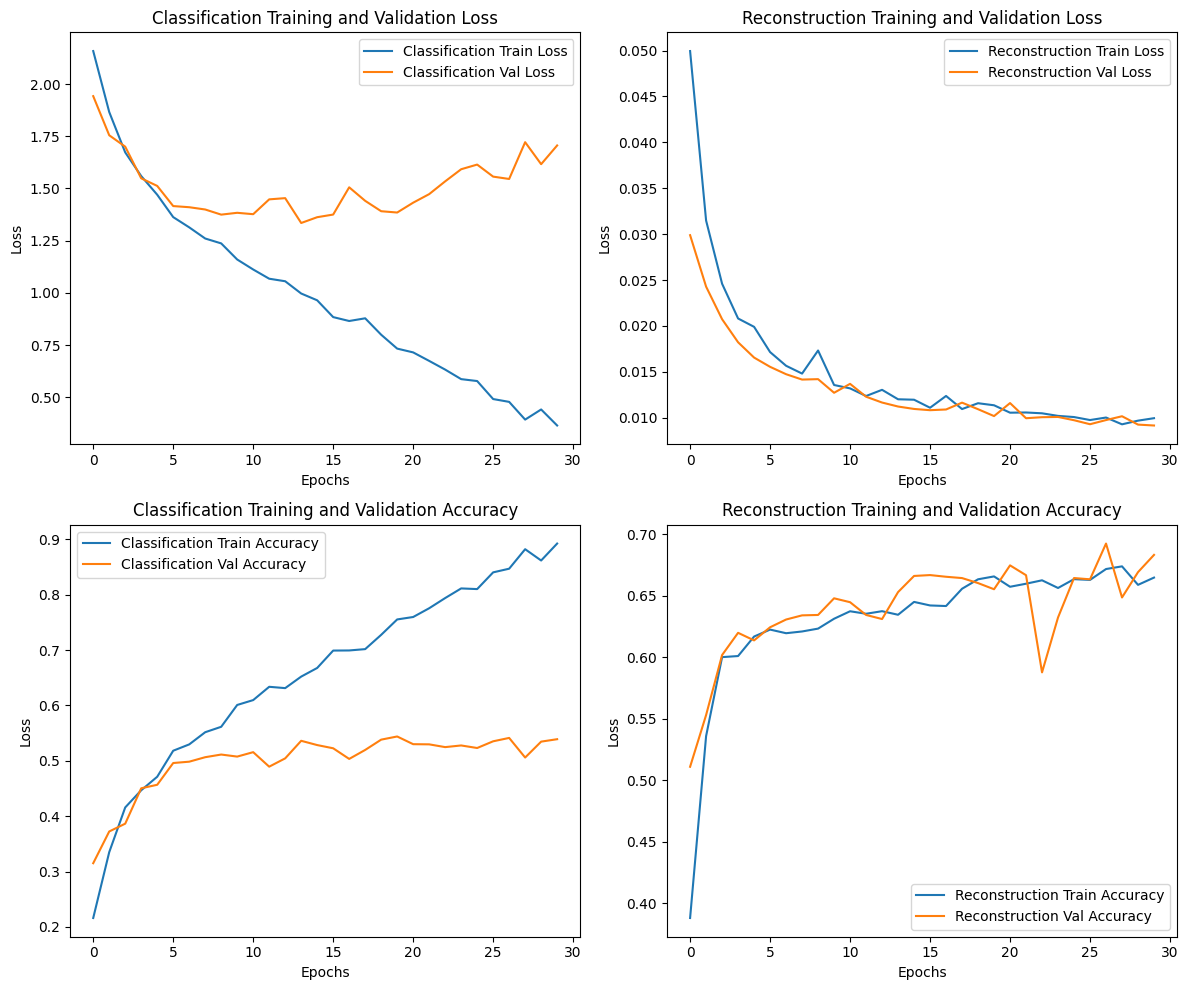

In [38]:
# plot the training history
plt.figure(figsize=(12, 10))

# classification training and validation losses
plt.subplot(2, 2, 1)
plt.plot(new_history.history['dense_15_loss'], label='Classification Train Loss')
plt.plot(new_history.history['val_dense_15_loss'], label='Classification Val Loss')
plt.title('Classification Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# reconstruction training and validation losses
plt.subplot(2, 2, 2)
plt.plot(new_history.history['conv2d_39_loss'], label='Reconstruction Train Loss')
plt.plot(new_history.history['val_conv2d_39_loss'], label='Reconstruction Val Loss')
plt.title('Reconstruction Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# classification training and validation accuracy
plt.subplot(2, 2, 3)
plt.plot(new_history.history['dense_15_accuracy'], label='Classification Train Accuracy')
plt.plot(new_history.history['val_dense_15_accuracy'], label='Classification Val Accuracy')
plt.title('Classification Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# reconstruction training and validation accuracy
plt.subplot(2, 2, 4)
plt.plot(new_history.history['conv2d_39_accuracy'], label='Reconstruction Train Accuracy')
plt.plot(new_history.history['val_conv2d_39_accuracy'], label='Reconstruction Val Accuracy')
plt.title('Reconstruction Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


plt.tight_layout()
plt.show()


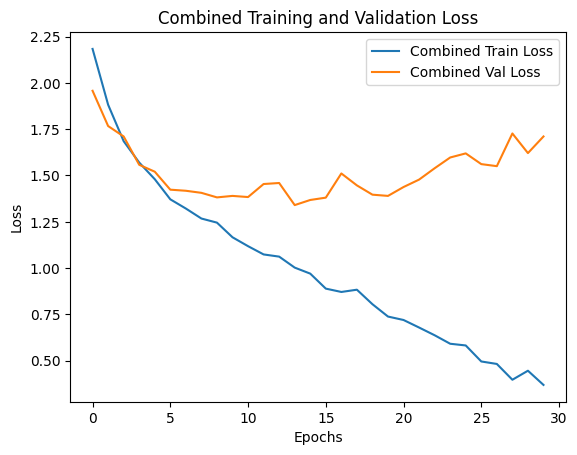

In [39]:
# combined training and validation losses
plt.plot(new_history.history['loss'], label='Combined Train Loss')
plt.plot(new_history.history['val_loss'], label='Combined Val Loss')
plt.title('Combined Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Task 4. Ensemble [6pts]